In [1]:
!pip install ultralytics -qq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.7/878.7 kB 22.0 MB/s eta 0:00:00


In [17]:
import cv2
from ultralytics import YOLO

import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm


import IPython
from IPython.display import Video, display
%matplotlib inline


import urllib.request
import shutil

In [18]:
# Video  path for experiment
path_zip = 'https://github.com/freedomwebtech/roiinyolo/raw/main/vid1.zip' # credits to the github repo for the video
urllib.request.urlretrieve(path_zip, "vid1.zip")



('vid1.zip', <http.client.HTTPMessage at 0x7d69e7ad6b30>)

In [19]:
import zipfile
import os

# Step 1: Specify the path to your zip file
zip_file_path = '/content/vid1.zip'  # Replace with your zip file path
# Step 2: Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")  # Specify your desired extraction path

# Step 3: List extracted files (optional, to verify)
extracted_files = os.listdir("/content/")
print("Extracted files:", extracted_files)

# Now you can access your video files in "/content/video_folder"


Extracted files: ['.config', 'yolov8x.pt', 'vid1.mp4', 'vid1.zip', 'sample_data']


In [20]:
path='/content/vid1.mp4'

In [21]:
model = YOLO('yolov8x.pt')

#geting names from classes
dict_classes = model.model.names

In [22]:
# Auxiliary functions
def risize_frame(frame, scale_percent):
    """Function to resize an image in a percent scale"""
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    return resized



def filter_tracks(centers, patience):
    """Function to filter track history"""
    filter_dict = {}
    for k, i in centers.items():
        d_frames = i.items()
        filter_dict[k] = dict(list(d_frames)[-patience:])

    return filter_dict


def update_tracking(centers_old,obj_center, thr_centers, lastKey, frame, frame_max):
    """Function to update track of objects"""
    is_new = 0
    lastpos = [(k, list(center.keys())[-1], list(center.values())[-1]) for k, center in centers_old.items()]
    lastpos = [(i[0], i[2]) for i in lastpos if abs(i[1] - frame) <= frame_max]
    # Calculating distance from existing centers points
    previous_pos = [(k,obj_center) for k,centers in lastpos if (np.linalg.norm(np.array(centers) - np.array(obj_center)) < thr_centers)]

    # if distance less than a threshold, it will update its positions
    if previous_pos:
        id_obj = previous_pos[0][0]
        centers_old[id_obj][frame] = obj_center

    # Else a new ID will be set to the given object
    else:
        if lastKey:
            last = lastKey.split('D')[1]
            id_obj = 'ID' + str(int(last)+1)
        else:
            id_obj = 'ID0'

        is_new = 1
        centers_old[id_obj] = {frame:obj_center}
        lastKey = list(centers_old.keys())[-1]

    return centers_old, id_obj, is_new, lastKey


In [23]:
# Parameters
verbose = False
scale_percent = 100
conf_level = 0.8
thr_centers = 20
frame_max = 5
patience = 100
alpha = 0.1

# Load video
video = cv2.VideoCapture(path)

# Objects to detect (e.g., person class in YOLOv5)
class_IDS = [0]
centers_old = {}
obj_id = 0
frames_list = []
count_p = 0
lastKey = ''
print(f'[INFO] - Verbose during Prediction: {verbose}')

# Original video information
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling video
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixel lines')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

# Video output setup
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(
    tmp_output_path,
    cv2.VideoWriter_fourcc(*VIDEO_CODEC),
    fps,
    (width, height)
)

# Define helper function to resize frame
def resize_frame(frame, scale_percent):
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    return cv2.resize(frame, (width, height))

# Execute object recognition
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):
    ret, frame = video.read()
    if not ret:
        break

    # Resize frame
    frame = resize_frame(frame, scale_percent)
    area_roi = [np.array([(1250, 400), (750, 400), (700, 800), (1200, 800)], np.int32)]
    ROI = frame[390:800, 700:1300]

    if verbose:
        print('Dimension Scaled (frame): ', (frame.shape[1], frame.shape[0]))

    # Perform prediction on the Region of Interest (ROI)
    y_hat = model.predict(ROI, conf=conf_level, classes=class_IDS, device=0, verbose=False)

    # Corrected DataFrame with bounding box data, confidence, and class information
    positions_frame = pd.DataFrame(y_hat[0].boxes.xyxy.cpu().numpy(), columns=['xmin', 'ymin', 'xmax', 'ymax'])
    positions_frame['conf'] = y_hat[0].boxes.conf.cpu().numpy()
    positions_frame['class'] = y_hat[0].boxes.cls.cpu().numpy()

    # Translate numeric class labels to text labels
    labels = [dict_classes[i] for i in positions_frame['class']]

    for ix, row in positions_frame.iterrows():
        xmin, ymin, xmax, ymax, confidence, category = row.astype('int')

        # Calculate center of bounding box
        center_x, center_y = int((xmax + xmin) / 2), int((ymax + ymin) / 2)

        # Update tracking
        centers_old, id_obj, is_new, lastKey = update_tracking(
            centers_old, (center_x, center_y), thr_centers, lastKey, i, frame_max
        )

        # Update people count in ROI
        count_p += is_new

        # Draw bounding box and center point
        cv2.rectangle(ROI, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
        for center_x, center_y in centers_old[id_obj].values():
            cv2.circle(ROI, (center_x, center_y), 5, (0, 0, 255), -1)

        # Label bounding box with object ID and confidence score
        cv2.putText(
            img=ROI, text=f'{id_obj}:{np.round(confidence, 2)}',
            org=(xmin, ymin - 10), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
            fontScale=0.8, color=(0, 0, 255), thickness=1
        )

    # Draw people count on the frame
    cv2.putText(
        img=frame, text=f'Counts People in ROI: {count_p}',
        org=(30, 40), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
        fontScale=1.5, color=(255, 0, 0), thickness=1
    )

    # Filter track history
    centers_old = filter_tracks(centers_old, patience)

    # Draw ROI area
    overlay = frame.copy()
    cv2.polylines(overlay, pts=area_roi, isClosed=True, color=(255, 0, 0), thickness=2)
    cv2.fillPoly(overlay, area_roi, (255, 0, 0))
    frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

    # Save frame
    frames_list.append(frame)
    output_video.write(frame)

# Release video writer
output_video.release()

# Post-process the video for notebook compatibility
if os.path.exists(output_path):
    os.remove(output_path)

subprocess.run(
    ["ffmpeg", "-i", tmp_output_path, "-crf", "18", "-preset", "veryfast",
     "-hide_banner", "-loglevel", "error", "-vcodec", "libx264", output_path]
)
os.remove(tmp_output_path)


[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (1920, 1080)


  0%|          | 0/341 [00:00<?, ?it/s]

In [24]:
print(len(frames_list))

341


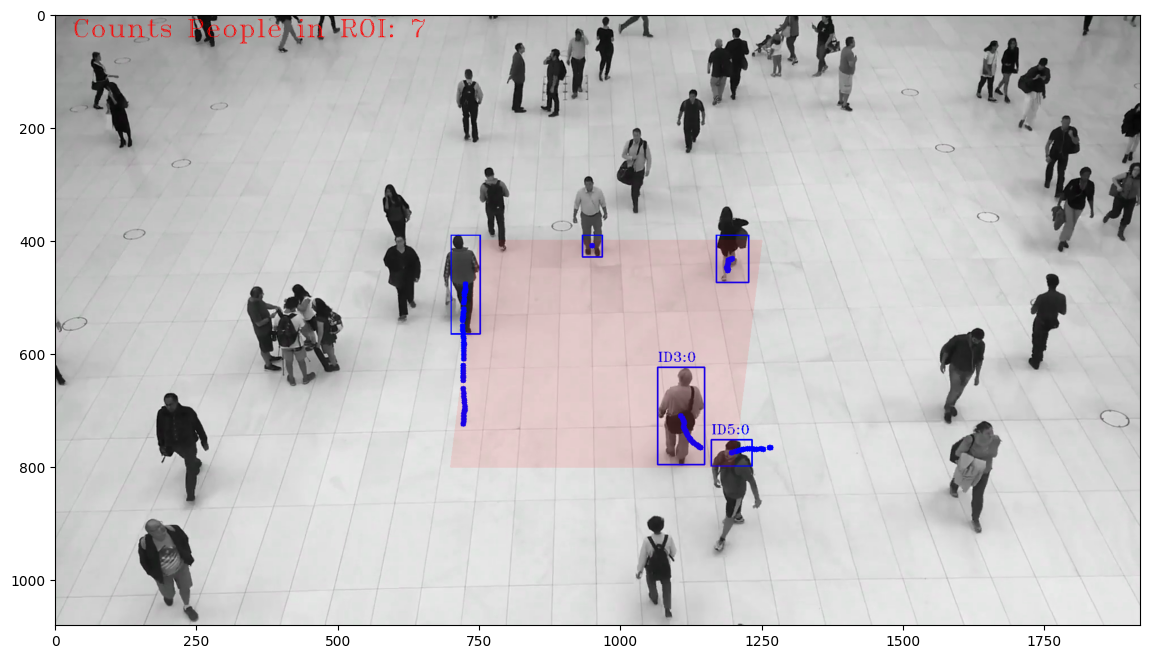

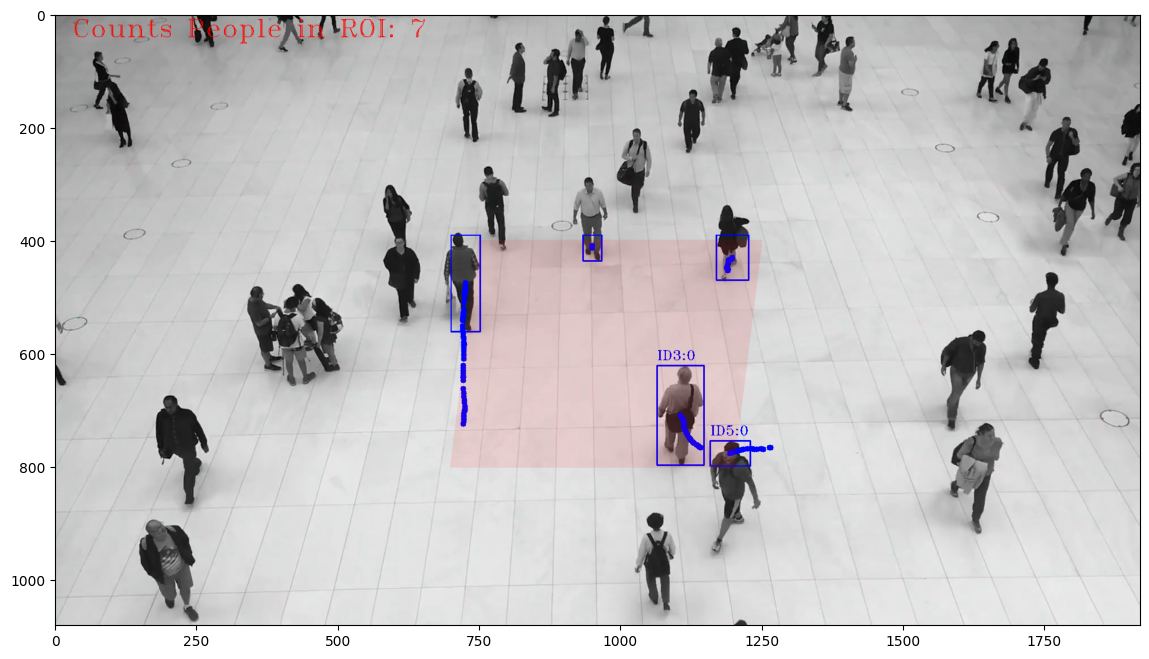

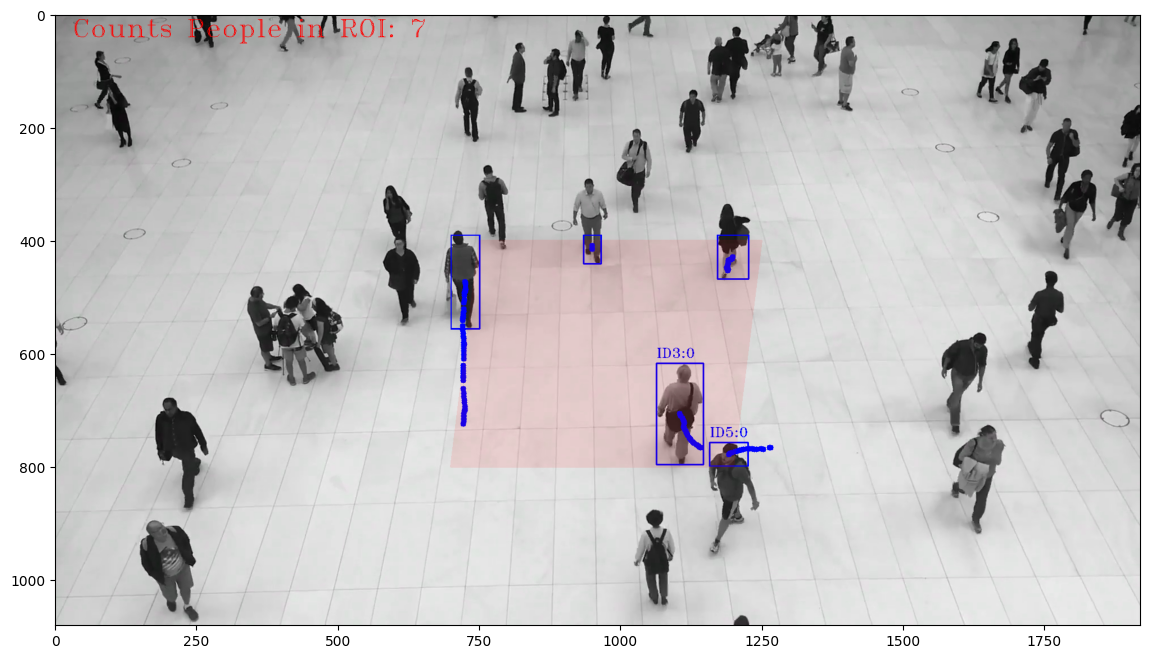

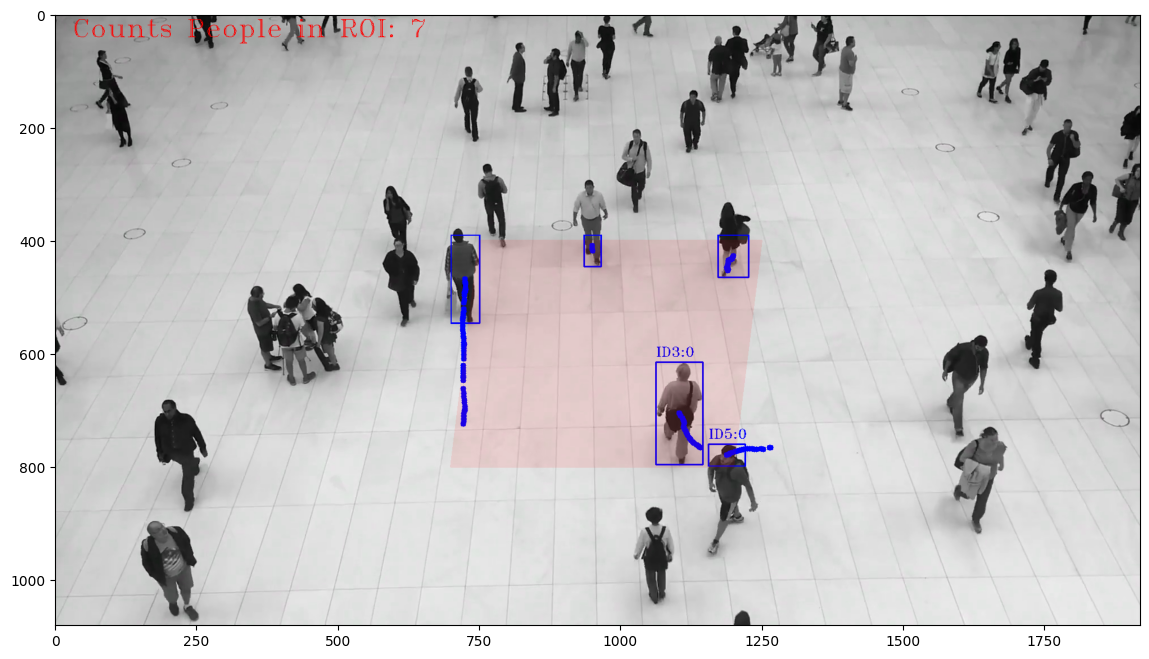

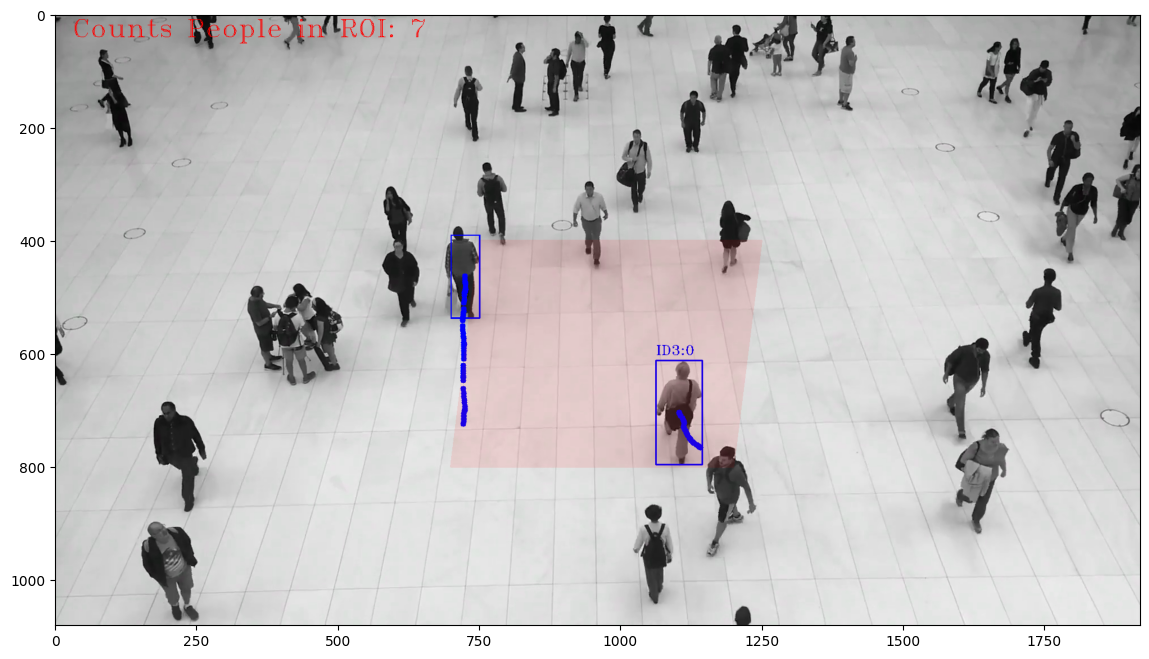

In [25]:
# Checking samples of processed frames
for i in [62,63, 64, 65, 66]:
    plt.figure(figsize =( 14, 10))
    plt.imshow(frames_list[i])
    plt.show()


In [26]:
#output video result
frac = 0.7
Video(data='p_v_result.mp4', embed=True, height=int(720 * frac), width=int(1280 * frac))
